In [1]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import os
import numpy as np
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import mysql.connector
from sklearn.metrics import confusion_matrix

In [ ]:
#Vor dem laden der Daten, müssen die Zugangsdaten zur Datenbank in der variables.env hinterlegt werden
load_dotenv()

## Daten aus Datenbank laden

In [ ]:
#variablen für die Datenbankverbindung auslesen
benutzer = os.getenv('DB_USER')
passwort = os.getenv('DB_PASSWORD')
server = os.getenv('DB_SERVER')
db = os.getenv('DB_NAME')
port = int(os.getenv('DB_PORT'))

In [3]:
#Datenbankverbindung
datenbank = mysql.connector.connect(
    host = server,
    user = benutzer,
    password = passwort,
    database = db,
    port = port,
    auth_plugin = 'mysql_native_password',
    connect_timeout=100000
)


In [4]:
#laden der strukturierten Daten aus Datenbank und speichern in Dataframe
data = pd.read_sql_query("SELECT * FROM wartung", datenbank)

C:\Users\User\AppData\Local\Temp\ipykernel_7844\2432445196.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query("SELECT * FROM wartung", datenbank)


## Daten aufbereiten

In [5]:
#Datentypen ausgeben
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1095 non-null   int64  
 1   MaschinenID       1095 non-null   object 
 2   Datum             1095 non-null   object 
 3   Zeit              1095 non-null   object 
 4   Druck             1095 non-null   float64
 5   Temperatur        1095 non-null   float64
 6   Vibration         1095 non-null   float64
 7   Anzahlwarning     1095 non-null   int64  
 8   Ausschuss         1095 non-null   float64
 9   Produktionsindex  1095 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 85.7+ KB
None


In [6]:
#Anzahl Nullwerte
print("Datentypen:")
print(data.isnull().sum())

Datentypen:
MesswertID          0
MaschinenID         0
Datum               0
Zeit                0
Druck               0
Temperatur          0
Vibration           0
Anzahlwarning       0
Ausschuss           0
Produktionsindex    0
dtype: int64


In [7]:
#Datensätze mit Duplikaten entfernen
data.drop_duplicates(inplace=True)
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1095 non-null   int64  
 1   MaschinenID       1095 non-null   object 
 2   Datum             1095 non-null   object 
 3   Zeit              1095 non-null   object 
 4   Druck             1095 non-null   float64
 5   Temperatur        1095 non-null   float64
 6   Vibration         1095 non-null   float64
 7   Anzahlwarning     1095 non-null   int64  
 8   Ausschuss         1095 non-null   float64
 9   Produktionsindex  1095 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 85.7+ KB
None


In [8]:
print(data.head())

   MesswertID MaschinenID       Datum   Zeit    Druck  Temperatur  Vibration  \
0       12478          A1  01.02.2022  06:00  47.6190     61.9048    28.5714   
1       12479          A1  01.02.2022  06:05  48.5714     62.8571    47.6190   
2       12480          A1  01.02.2022  06:10  57.1429     76.1905    33.3333   
3       12481          A1  01.02.2022  06:15   0.0000      0.0000     0.0000   
4       12482          A1  01.02.2022  06:20   0.0000      0.0000     0.0000   

   Anzahlwarning  Ausschuss  Produktionsindex  
0              3        2.0                85  
1              5        3.0                87  
2             12       11.0                91  
3              2        0.0                84  
4              2        0.0                85  


### Fehlerhafte Daten  beim Datum identifizieren und korrigieren

In [9]:
#konvertieren von Datum in datetime und entfernen von Uhrzeit und Zeitzone
data['Datum'] = pd.to_datetime(data['Datum'], format='%d.%m.%Y', errors='coerce').dt.date
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1095 non-null   int64  
 1   MaschinenID       1095 non-null   object 
 2   Datum             1086 non-null   object 
 3   Zeit              1095 non-null   object 
 4   Druck             1095 non-null   float64
 5   Temperatur        1095 non-null   float64
 6   Vibration         1095 non-null   float64
 7   Anzahlwarning     1095 non-null   int64  
 8   Ausschuss         1095 non-null   float64
 9   Produktionsindex  1095 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 85.7+ KB
None


In [10]:
#konvertieren von Zeit in Datetime, wenn Wert nicht nutzbar dann NaN
data['Zeit'] = pd.to_datetime(data['Zeit'], format='%H:%M', errors='coerce').dt.time
d1 = data

### Neue Ausfall Spalte hinzufügen

In [11]:
#neue Spalte für Ausfall hinzufügen 
d1['Ausfall'] = np.where((d1['Druck'] == 0) & (d1['Temperatur'] == 0) & (d1['Vibration'] == 0) & (d1['Ausschuss'] == 0), 1, 0)
print(d1.head(10))
d2 = d1

   MesswertID MaschinenID       Datum      Zeit    Druck  Temperatur  \
0       12478          A1  2022-02-01  06:00:00  47.6190     61.9048   
1       12479          A1  2022-02-01  06:05:00  48.5714     62.8571   
2       12480          A1  2022-02-01  06:10:00  57.1429     76.1905   
3       12481          A1  2022-02-01  06:15:00   0.0000      0.0000   
4       12482          A1  2022-02-01  06:20:00   0.0000      0.0000   
5       12483          A1  2022-02-01  06:25:00   0.0000      0.0000   
6       12484          A1  2022-02-01  06:30:00   0.0000      0.0000   
7       12485          A1  2022-02-01  06:35:00   0.0000      0.0000   
8       12486          A1  2022-02-01  06:40:00   0.0000      0.0000   
9       12487          A1  2022-02-01  06:45:00   0.0000      0.0000   

   Vibration  Anzahlwarning  Ausschuss  Produktionsindex  Ausfall  
0    28.5714              3        2.0                85        0  
1    47.6190              5        3.0                87        0  
2  

In [12]:
print(d2['Ausfall'].value_counts())

Ausfall
0    807
1    288
Name: count, dtype: int64


In [13]:
#neue Spalte für Fehlerhafte Werte hinzufügen
d2['Error'] = np.where((d2['Ausfall'] == 0) & ((d2['Druck'] == 0) | (d2['Temperatur'] == 0) | (d2['Vibration'] == 0)), 1, 0)
#Anzahl der Fehlerhaften Werte
print(d2['Error'].value_counts())

Error
0    1065
1      30
Name: count, dtype: int64


In [14]:
#30 errors können gelöscht werden, da unter 1% der Daten
d2 = d2[d2['Error'] == 0]
d2 = d2.drop(['Error'], axis=1)
print(d2.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1065 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1065 non-null   int64  
 1   MaschinenID       1065 non-null   object 
 2   Datum             1056 non-null   object 
 3   Zeit              1056 non-null   object 
 4   Druck             1065 non-null   float64
 5   Temperatur        1065 non-null   float64
 6   Vibration         1065 non-null   float64
 7   Anzahlwarning     1065 non-null   int64  
 8   Ausschuss         1065 non-null   float64
 9   Produktionsindex  1065 non-null   int64  
 10  Ausfall           1065 non-null   int32  
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 95.7+ KB
None


In [15]:
#In der Datumsspalte gibt es leere Werte da diese nicht in einem gültigen Format sind. Diese Zeilen können gelöscht werden, da sie nur 0,1% der Daten ausmachen (alternativ könnte man die Annahme treffen, dass diese, da am ende dem 08.02. zugeordnet werden können (input))
d2 = d2.dropna(subset=['Datum'])
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1056 entries, 0 to 1085
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1056 non-null   int64  
 1   MaschinenID       1056 non-null   object 
 2   Datum             1056 non-null   object 
 3   Zeit              1056 non-null   object 
 4   Druck             1056 non-null   float64
 5   Temperatur        1056 non-null   float64
 6   Vibration         1056 non-null   float64
 7   Anzahlwarning     1056 non-null   int64  
 8   Ausschuss         1056 non-null   float64
 9   Produktionsindex  1056 non-null   int64  
 10  Ausfall           1056 non-null   int32  
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 94.9+ KB
None


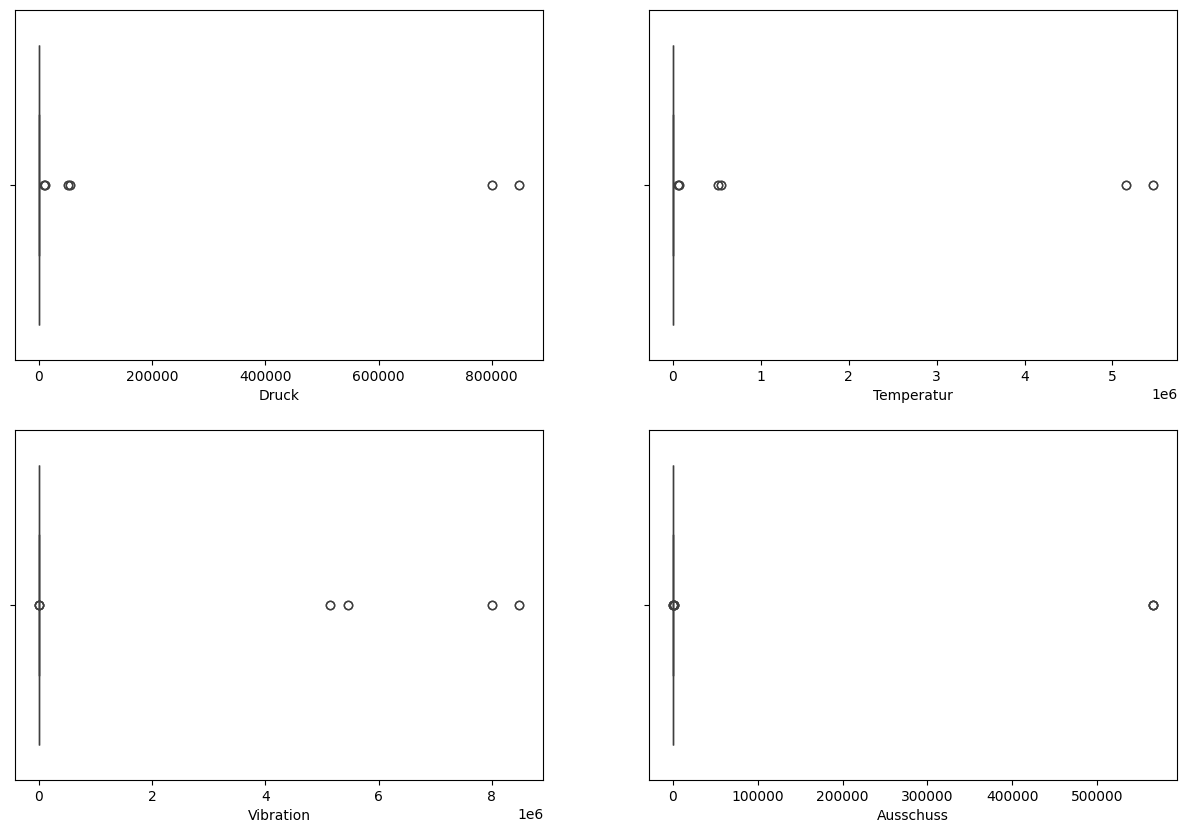

In [16]:
#Ausreiser erkennen für Druck, Temperatur, Vibration und Ausschuss in einem boxplot mit seaborn
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.boxplot(x=d2['Druck'], ax=ax[0,0])
sns.boxplot(x=d2['Temperatur'], ax=ax[0,1])
sns.boxplot(x=d2['Vibration'], ax=ax[1,0])
sns.boxplot(x=d2['Ausschuss'], ax=ax[1,1])
plt.show()

In [17]:
#ausreißer entfernen druck über 100 aber leere behalten
d2 = d2[(d2['Druck'] < 100) | (d2['Druck'].isnull())]
d2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1044 entries, 0 to 1085
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1044 non-null   int64  
 1   MaschinenID       1044 non-null   object 
 2   Datum             1044 non-null   object 
 3   Zeit              1044 non-null   object 
 4   Druck             1044 non-null   float64
 5   Temperatur        1044 non-null   float64
 6   Vibration         1044 non-null   float64
 7   Anzahlwarning     1044 non-null   int64  
 8   Ausschuss         1044 non-null   float64
 9   Produktionsindex  1044 non-null   int64  
 10  Ausfall           1044 non-null   int32  
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 93.8+ KB


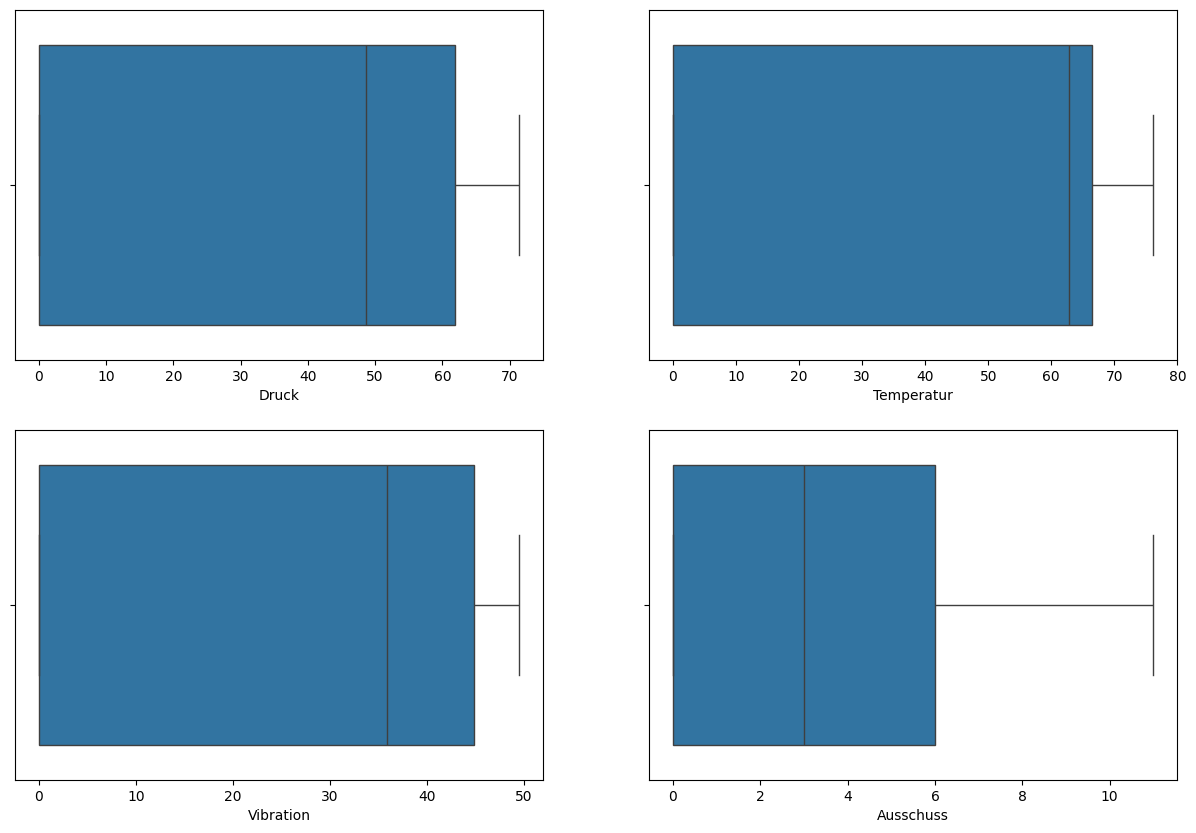

In [18]:
#Ausreißer überprüfen
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.boxplot(x=d2['Druck'], ax=ax[0,0])
sns.boxplot(x=d2['Temperatur'], ax=ax[0,1])
sns.boxplot(x=d2['Vibration'], ax=ax[1,0])
sns.boxplot(x=d2['Ausschuss'], ax=ax[1,1])
plt.show()

In [19]:
d4 = d2
d3 = d2
d3.drop(['Datum', 'Zeit','MaschinenID'], axis=1, inplace=True)

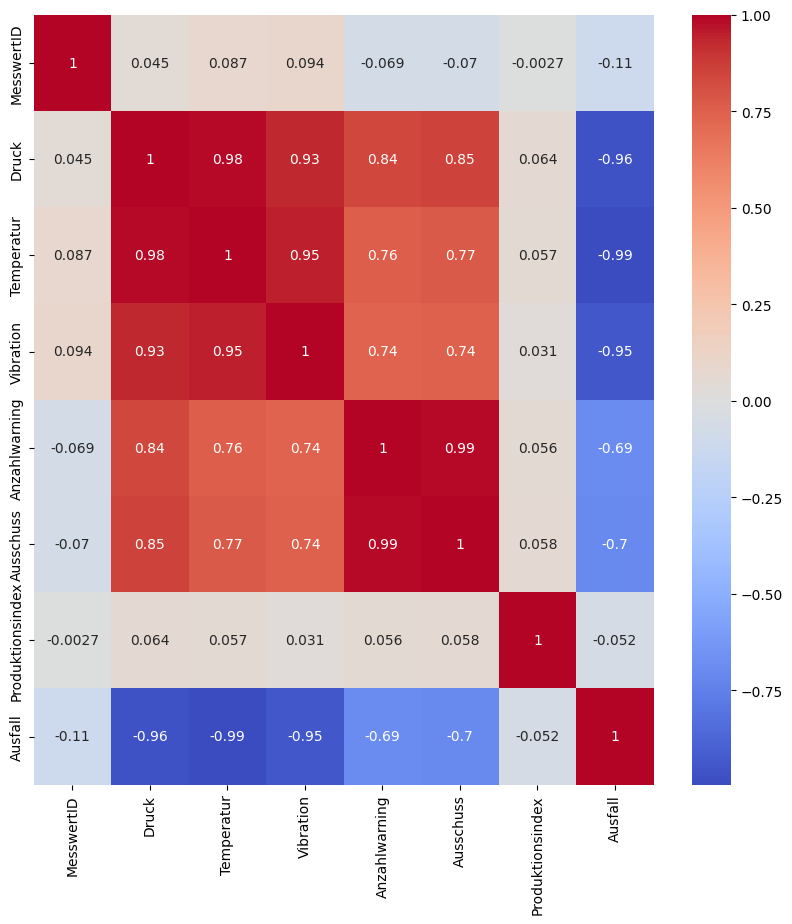

In [20]:
#korrelationen anzeigen
correlation = d3.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [21]:
#irrelevante spalten entfernen (man erkennt dass der Produktionsindex sehr unregelmäßig verteilt ist und keine Korrelation zu den anderen Werten hat)
d4 = d4.drop([ 'Produktionsindex','MesswertID'], axis=1)

#### Rollender Mittelwert:

In [22]:
#rollender mittelwert hinzufügen
d4['Druck_rolling'] = d3['Druck'].rolling(window=12).mean()
d4['Vibration_rolling'] = d3['Vibration'].rolling(window=12).mean()
d4['Temperatur_rolling'] = d3['Temperatur'].rolling(window=12).mean()
d4['Ausschuss_rolling'] = d3['Ausschuss'].rolling(window=12).mean()
d4['Anzahlwarning_rolling'] = d3['Anzahlwarning'].rolling(window=12).mean()

In [23]:
#rollende standardabweichung hinzufügen
d4['Druck_std'] = d3['Druck'].rolling(window=12).std()
d4['Vibration_std'] = d3['Vibration'].rolling(window=12).std()
d4['Temperatur_std'] = d3['Temperatur'].rolling(window=12).std()
d4['Anzahlwarning_std'] = d3['Anzahlwarning'].rolling(window=12).std()

In [24]:
#andere spalten entfernen
d4 = d4.drop(['Druck', 'Vibration', 'Temperatur', 'Ausschuss',"Anzahlwarning"], axis=1)
d4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1044 entries, 0 to 1085
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ausfall                1044 non-null   int32  
 1   Druck_rolling          1033 non-null   float64
 2   Vibration_rolling      1033 non-null   float64
 3   Temperatur_rolling     1033 non-null   float64
 4   Ausschuss_rolling      1033 non-null   float64
 5   Anzahlwarning_rolling  1033 non-null   float64
 6   Druck_std              1033 non-null   float64
 7   Vibration_std          1033 non-null   float64
 8   Temperatur_std         1033 non-null   float64
 9   Anzahlwarning_std      1033 non-null   float64
dtypes: float64(9), int32(1)
memory usage: 85.6 KB


In [25]:
#fill NaN values with 0
d4 = d4.fillna(0)

In [26]:
d4.describe()

,Ausfall,Druck_rolling,Vibration_rolling,Temperatur_rolling,Ausschuss_rolling,Anzahlwarning_rolling,Druck_std,Vibration_std,Temperatur_std,Anzahlwarning_std
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,0.275862,39.727940,28.540847,46.536921,3.530252,5.019636,15.341296,13.401656,16.744209,2.256219
std,0.447162,16.928659,12.181203,19.882491,1.870546,1.901900,13.560029,7.097356,15.321920,1.414042
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,27.930546,19.047600,30.198410,2.500000,3.916667,0.497375,9.808155,0.497322,0.792961
50%,0.000000,45.489863,31.984100,52.460313,2.916667,4.416667,18.730672,12.839514,19.931473,2.282165
75%,1.000000,48.174567,39.285675,62.460308,4.916667,6.416667,29.170720,20.312569,32.193656,3.528026
max,1.000000,65.547608,43.619042,70.079358,8.166667,9.583333,36.017949,24.136274,37.374398,5.262791


In [27]:
df_reset = d4.reset_index(drop=True)


Man erkennt, dass die Vibration und Temperatur am meisten Einfluss haben

In [28]:
#Zielvariabl und Features trennen
X = df_reset.drop('Ausfall', axis=1) 
y = df_reset['Ausfall']  

In [29]:
#train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Testen der Unterschiedlichen Modelle

In [30]:
#trainieren des Logistischen Regressionsmodells
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
#Ergebnisse ausgeben
predictions = logmodel.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       148
           1       0.75      0.59      0.66        61

    accuracy                           0.82       209
   macro avg       0.80      0.75      0.77       209
weighted avg       0.82      0.82      0.82       209



c:\Users\User\Documents\big-data-management\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
#trainieren des Random Forest Modells
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
#Ergebnisse ausgeben
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred))


              precision    recall  f1-score   support

           0       0.91      0.99      0.95       148
           1       0.96      0.77      0.85        61

    accuracy                           0.92       209
   macro avg       0.94      0.88      0.90       209
weighted avg       0.93      0.92      0.92       209



In [32]:
#trainieren des Gradient Boosting Modells
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
#Ergebnisse ausgeben
gb_predictions = gb.predict(X_test)
print(classification_report(y_test,gb_predictions))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       148
           1       0.93      0.84      0.88        61

    accuracy                           0.93       209
   macro avg       0.93      0.90      0.92       209
weighted avg       0.93      0.93      0.93       209



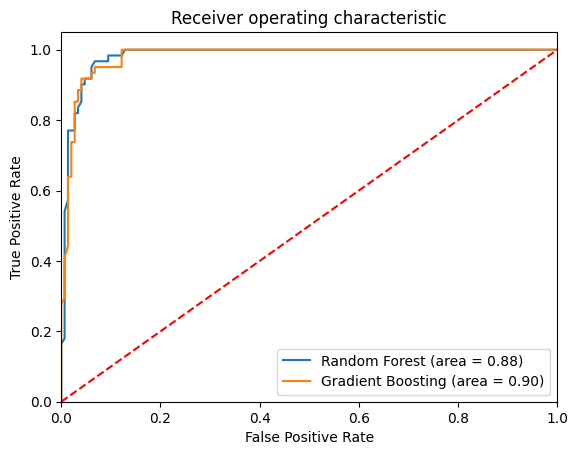

In [33]:
#Vergleichen der 2 besten Modelle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rfc_roc_auc = roc_auc_score(y_test, rfc.predict(X_test))
rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
gb_roc_auc = roc_auc_score(y_test, gb.predict(X_test))
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest (area = %0.2f)' % rfc_roc_auc)
plt.plot(gb_fpr, gb_tpr, label='Gradient Boosting (area = %0.2f)' % gb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

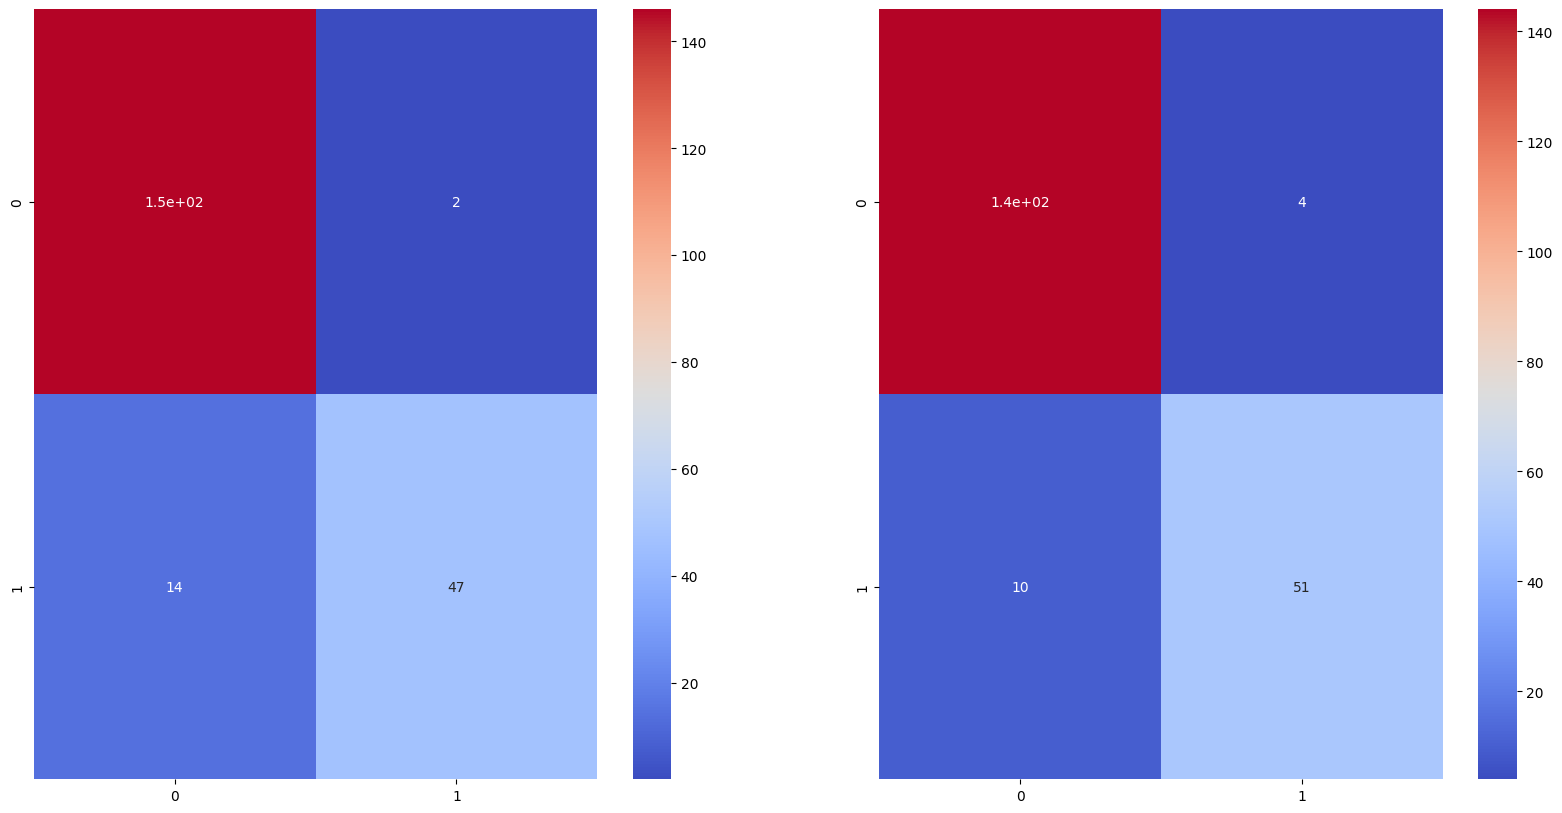

In [34]:
#Vergleichen der 2 besten Modelle mit sns confusion matrix
conf_mat = confusion_matrix(y_test, rfc_pred)
conf_mat2 = confusion_matrix(y_test, gb_predictions)
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.heatmap(conf_mat, annot=True, cmap='coolwarm', ax=ax[0])
sns.heatmap(conf_mat2, annot=True, cmap='coolwarm', ax=ax[1])
plt.show()


## Entscheidung für das Gradient Boosting Model

In [35]:
#Wahrschienlichkeit für Ausfall berechnen
y_pred = gb.predict_proba(X_test)[:,1]

In [36]:
y_pred = pd.DataFrame(y_pred, columns=['Probability'])
y_pred['Actual'] = y_test.values
y_pred['Predicted'] = predictions
y_pred['Error'] = np.where(y_pred['Actual'] == y_pred['Predicted'], 0, 1)
y_pred['Error'].value_counts()

Error
0    172
1     37
Name: count, dtype: int64

In [37]:
y_pred

,Probability,Actual,Predicted,Error
0,0.006976,0,0,0
1,0.645474,0,0,0
2,0.015336,0,0,0
3,0.023409,0,0,0
4,0.020602,0,0,0
...,...,...,...,...
204,0.008145,0,0,0
205,0.362501,0,0,0
206,0.017429,0,0,0
207,0.006976,0,0,0


In [38]:
#testen wie die verteilung der zielvariable ist und in % anzeigen
d4['Ausfall'].value_counts(normalize=True) * 100

Ausfall
0    72.413793
1    27.586207
Name: proportion, dtype: float64

Eine Verteilung von 50/50 ist bestrebenswerte, jedoch wird diese nicht erreicht wodurch eine Methode zum Normalisieren angewendet werden müsste

In [39]:
#testen wie das Modell performt wenn die Zielvariable normalisiert wird
from sklearn.utils import resample
#Separieren der Zielvariablen
df_majority = d4[d4.Ausfall==0]
df_minority = d4[d4.Ausfall==1]
#Upsamlpling der Minderheit
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=700,    
                                 random_state=42) 
#Kombinieren der Mehrheit und der upgesamplten Minderheit
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
#Anzeigen der neuen Verteilung
df_upsampled.Ausfall.value_counts()


Ausfall
0    756
1    700
Name: count, dtype: int64

In [40]:
X_up = df_upsampled.drop('Ausfall', axis=1)
y_up = df_upsampled['Ausfall']
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, test_size=0.2, random_state=42)

In [41]:
#trainieren des Gradient Boosting Modells
from sklearn.ensemble import GradientBoostingClassifier
gb_up = GradientBoostingClassifier()
gb_up.fit(X_train_up, y_train_up)
#Ergebnisse ausgeben
gb_predictions_up = gb.predict(X_test_up)
print(classification_report(y_test_up,gb_predictions_up))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       154
           1       0.97      0.98      0.97       138

    accuracy                           0.98       292
   macro avg       0.98      0.98      0.98       292
weighted avg       0.98      0.98      0.98       292



c:\Users\User\Documents\big-data-management\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
1 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\Documents\big-data-management\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\Documents\big-data-management\.venv\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\Documents\big-data-mana

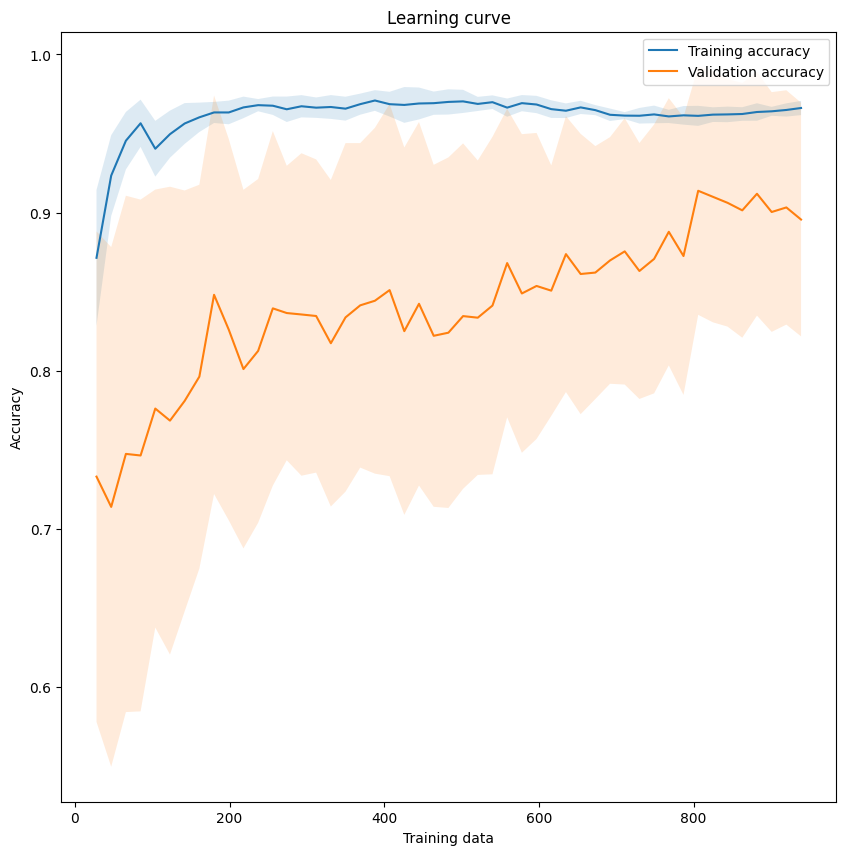

In [42]:
#Lernkurven für gradient boosting modell plotten
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(gb, X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10,10))
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15)
plt.plot(train_sizes, test_mean, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15)
plt.title('Learning curve')
plt.xlabel('Training data')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



c:\Users\User\Documents\big-data-management\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
260 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
260 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\Documents\big-data-management\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\Documents\big-data-management\.venv\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\Documents\big-data-

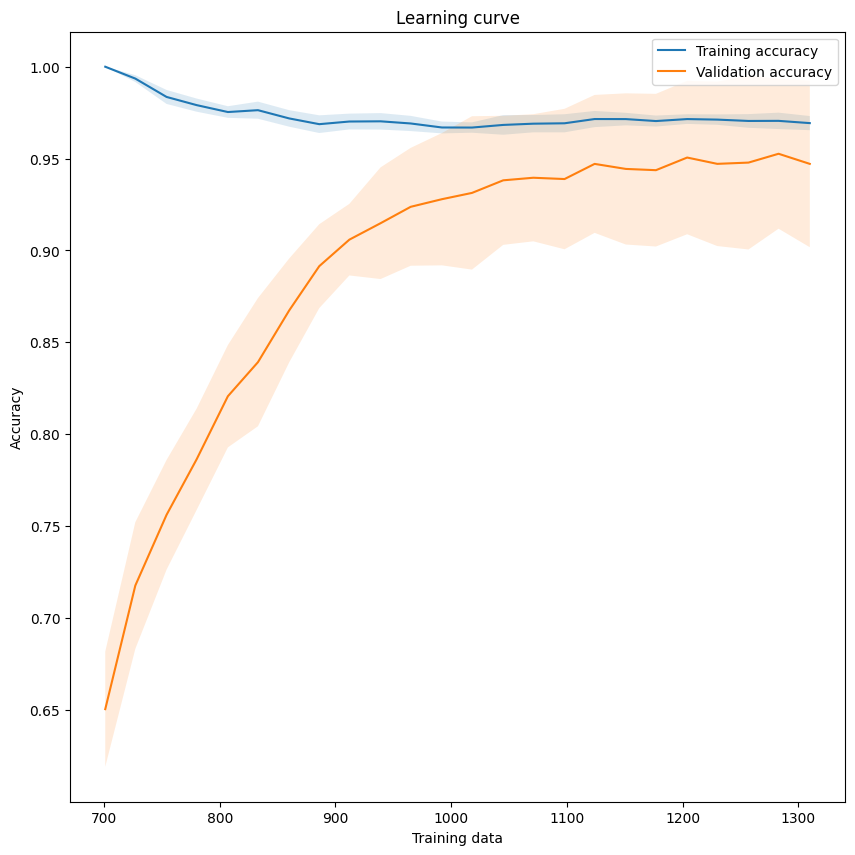

In [43]:
#Lernkurven für gradient boosting modell (normalisiert) plotten
train_sizes, train_scores, test_scores = learning_curve(gb_up, X_up, y_up, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10,10))
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15)
plt.plot(train_sizes, test_mean, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15)
plt.title('Learning curve')
plt.xlabel('Training data')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Man erkennt, dass bei einer normalisierten Zielvariable eine noch genauere prediction erzielt werden kann.

## Prüfen der Einflussfkatoren

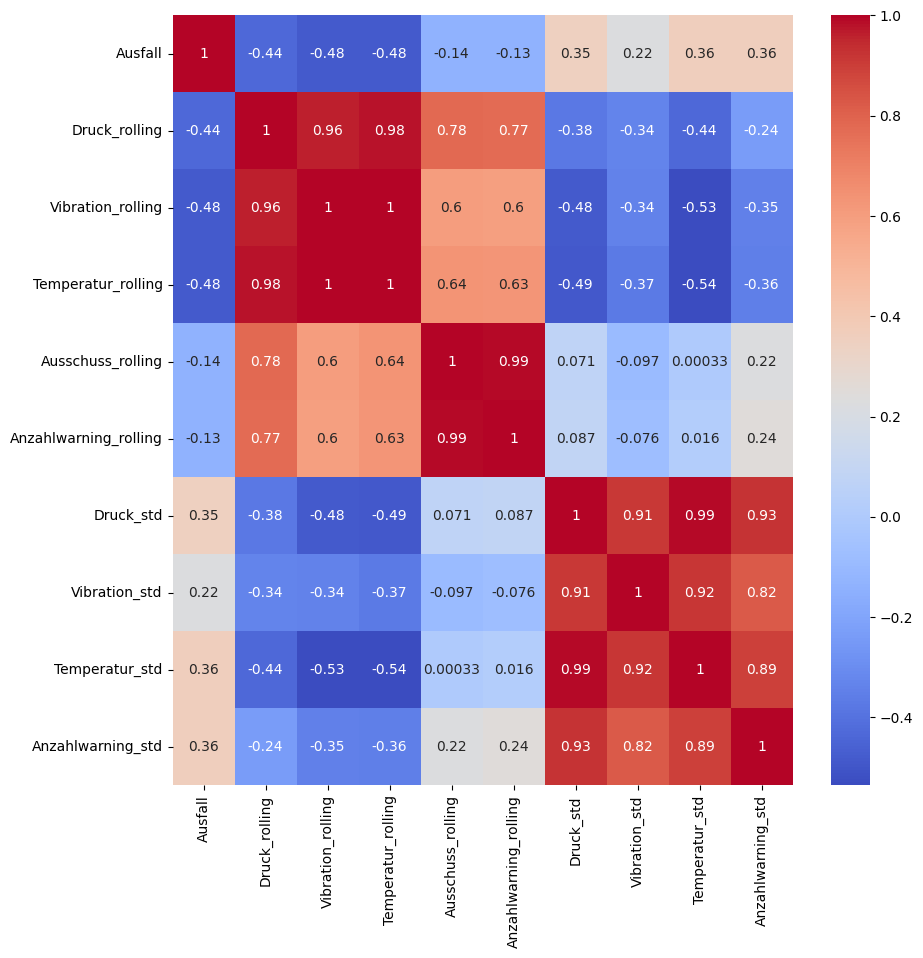

In [44]:
#Korrellationen anzeigen
correlation = d4.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

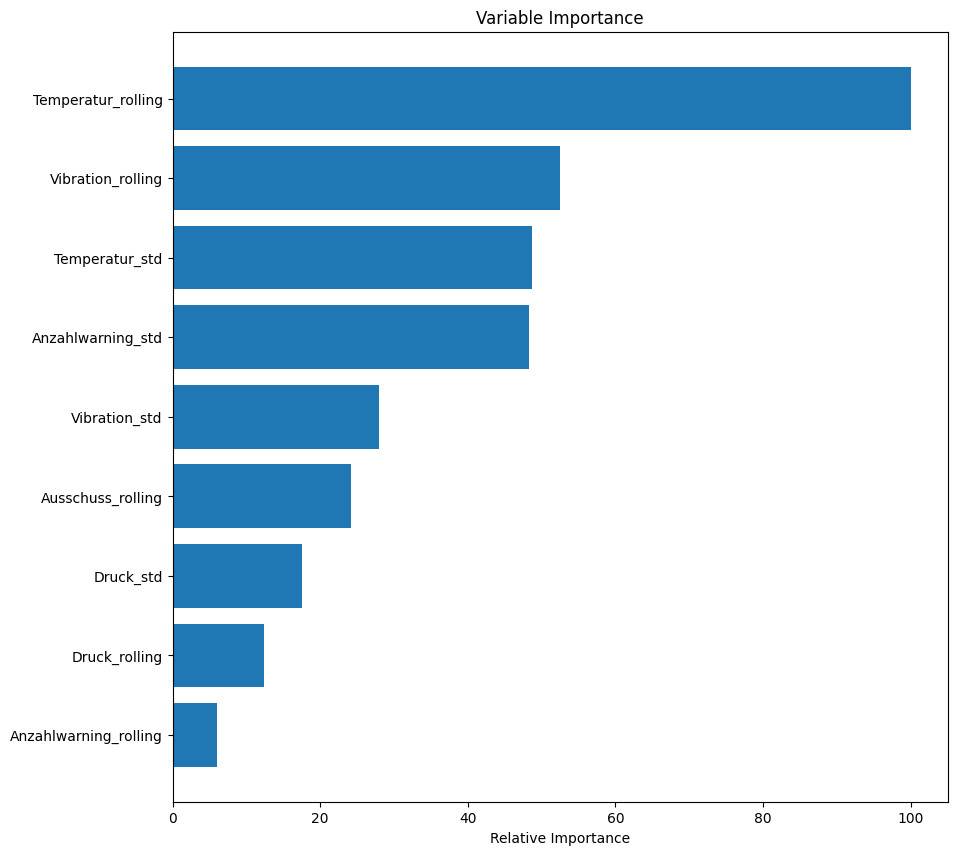

In [45]:
#Feature importance anzeigen
feature_importance = gb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [46]:
#Modell speichern
import pickle
filename = 'finalized_model.pkl'
pickle.dump(gb, open(filename, 'wb'))

In [47]:
#save requirements.txt
!pip freeze > requirements.txt

## Datenanalyse

Datenanalyse mit Klassifikationsmodell auf die Zielvariable Ausfall

Import benötigter Pakete:

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

Aufteilung der Daten in Trainings- und Testdaten von d2:


In [49]:
X1 = d2[['Druck', 'Vibration', 'Temperatur', 'Ausschuss', 'Produktionsindex']]
y1 = d2['Ausfall']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

Aufteilung der Daten in Trainings- und Testdaten von d3:

In [50]:
X2 = d3[['Druck', 'Vibration', 'Temperatur', 'Ausschuss', 'Produktionsindex']]
y2 = d2['Ausfall']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

### Modellbildung mit Gradient boost:

In [51]:
# Initialisierung des Modells
model = HistGradientBoostingClassifier()

# Anpassung des Modells an die Trainingsdaten
model.fit(X1_train, y1_train)

# Vorhersagen auf den Testdaten
y1_pred = model.predict(X1_test)

Bewertung des Modells Gradient Boost:

In [52]:
accuracy = accuracy_score(y1_test, y1_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y1_test, y1_pred)

# Recall
recall = recall_score(y1_test, y1_pred)

# F1-Score
f1 = f1_score(y1_test, y1_pred)

# AUC-ROC Score
roc_auc = roc_auc_score(y1_test, y1_pred)

# Zeige die Ergebnisse an
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC-ROC Score: {roc_auc}')

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
AUC-ROC Score: 1.0


In [ ]:
# Darstellung der Confusion Matrix
conf_matrix1 = confusion_matrix(y1_test, y1_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Modellbildung mit Random Forrest: 

Hier wurden alle Daten die NaN sind durch 0 ersetzt weil weil das Modell nicht mit NaN werten arbeiten kann

In [ ]:
# Initialisierung des Modells
model = RandomForestClassifier()

# Anpassung des Modells an die Trainingsdaten
model.fit(X2_train, y2_train)

# Vorhersagen auf den Testdaten
y2_pred = model.predict(X2_test)

In [ ]:
accuracy = accuracy_score(y2_test, y2_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y2_test, y2_pred)

# Recall
recall = recall_score(y2_test, y2_pred)

# F1-Score
f1 = f1_score(y2_test, y2_pred)

# AUC-ROC Score
roc_auc = roc_auc_score(y2_test, y2_pred)

# Zeige die Ergebnisse an
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC-ROC Score: {roc_auc}')

In [ ]:
# Darstellung der Confusion Matrix
conf_matrix2 = confusion_matrix(y2_test, y2_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Leider accuracy bei 1.0 gradient boost -> probieren:

Validierungsmethoden:

    Verwende korrekte Validierungsmethoden wie Kreuzvalidierung, um sicherzustellen, dass die Modellbewertung robust ist.
    Achte darauf, dass du nicht überoptimiert hast (Overfitting auf Trainingsdaten).

Imbalanced Classes:

    Überprüfe, ob deine Klassen im Datensatz unausgewogen sind. Wenn es eine signifikante Klassenasymmetrie gibt, könnte die Accuracy allein täuschen.
    Betrachte alternative Metriken wie Precision, Recall, F1-Score oder AUC-ROC, um die Leistung genauer zu bewerten.

Feature Engineering:

    Überlege, ob die verwendeten Features die relevanten Informationen enthalten. Manchmal könnte das Modell Overfitting auf bestimmte Muster in den Daten erleiden.

Hyperparameter-Tuning:

    Überprüfe die Hyperparameter des Modells. Es besteht die Möglichkeit, dass das Modell zu komplex ist und Overfitting auf den Trainingsdaten auftritt. Experimentiere mit verschiedenen Hyperparameter-Einstellungen.

Gewichtung der Klassen:

    Einige Klassifikationsalgorithmen, einschließlich Random Forest in scikit-learn, ermöglichen es dir, Klassen unterschiedlich zu gewichten. Du kannst das class_weight-Argument verwenden, um die Gewichtung der Klassen anzupassen. Ein höheres Gewicht für die Minderheitsklasse kann dazu beitragen, das Modell auf die selteneren Ereignisse zu fokussieren.

python

model = RandomForestClassifier(class_weight='balanced')

### Feature importance:

In [ ]:
# Feature Importance extrahieren
feature_importance = model.feature_importances_

# Die Namen der Features (Variablen)
feature_names = X2.columns

# Feature Importance in ein DataFrame umwandeln
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sortiere das DataFrame nach Importance in absteigender Reihenfolge
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot der Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.show()